# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откроем файл с данными и изучим общую информацию. 

In [ ]:
# импортируем необходимые для работы библиотеки и посмотрим 10 первых строк таблицы

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# уберем вывод чисел научным обозначением
pd.options.display.float_format = '{:.2f}'.format

try:
    df_raw = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    df_raw = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')

# создадим копию исходных данных которую будем использовать для дальнейших манипуляций    
df = df_raw.copy()

df.head(10)

pd.options.mode.chained_assignment = None 

#### Получим общую информацию о данных таблицы df, применив к ней метод info():

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

#### В названиях колонок не видно нарушения стиля, кроме столбца `cityCenters_nearest`. Приведем данный столбец к нажнему регистру:

In [ ]:
df.columns = df.columns.str.lower()

#### Применим к таблице df метод describe() и выведем на экран список характерных значений.

In [ ]:
# для удобства чтения, применим функцию T для транспонирования индекса и столбцов датафрейма
df.describe().T

,count,mean,std,min,25%,50%,75%,max
total_images,23699.00,9.86,5.68,0.00,6.00,9.00,14.00,50.00
last_price,23699.00,6541548.77,10887013.27,12190.00,3400000.00,4650000.00,6800000.00,763000000.00
total_area,23699.00,60.35,35.65,12.00,40.00,52.00,69.90,900.00
rooms,23699.00,2.07,1.08,0.00,1.00,2.00,3.00,19.00
ceiling_height,14504.00,2.77,1.26,1.00,2.52,2.65,2.80,100.00
floors_total,23613.00,10.67,6.60,1.00,5.00,9.00,16.00,60.00
living_area,21796.00,34.46,22.03,2.00,18.60,30.00,42.30,409.70
floor,23699.00,5.89,4.89,1.00,2.00,4.00,8.00,33.00
kitchen_area,21421.00,10.57,5.91,1.30,7.00,9.10,12.00,112.00
balcony,12180.00,1.15,1.07,0.00,0.00,1.00,2.00,5.00


В исходной таблице представлены 22 столбца, с описанием данных о проданных квартирах и их параметрах:

- `airports_nearest` — расстояние до ближайшего аэропорта в метрах (м)
- `balcony` — число балконов
- `ceiling_height` — высота потолков (м)
- `cityсenters_nearest` — расстояние до центра города (м)
- `days_exposition` — сколько дней было размещено объявление (от публикации до снятия)
- `first_day_exposition` — дата публикации
- `floor` — этаж
- `floors_total` — всего этажей в доме
- `is_apartment` — апартаменты (булев тип)
- `kitchen_area` — площадь кухни в квадратных метрах (м²)
- `last_price` — цена на момент снятия с публикации
- `living_area` — жилая площадь в квадратных метрах (м²)
- `locality_name` — название населённого пункта
- `open_plan` — свободная планировка (булев тип)
- `parks_around3000` — число парков в радиусе 3 км
- `parks_nearest` — расстояние до ближайшего парка (м)
- `ponds_around3000` — число водоёмов в радиусе 3 км
- `ponds_nearest` — расстояние до ближайшего водоёма (м)
- `rooms` — число комнат
- `studio` — квартира-студия (булев тип)
- `total_area` — общая площадь квартиры в квадратных метрах (м²)
- `total_images` — число фотографий квартиры в объявлении

#### Построим общую гистограмму для всех числовых столбцов таблицы с помощью метода hist().

Гистограмма объединит числовые значения по диапазонам и покажет, как часто в нашем наборе данных встречается то или иное значение.

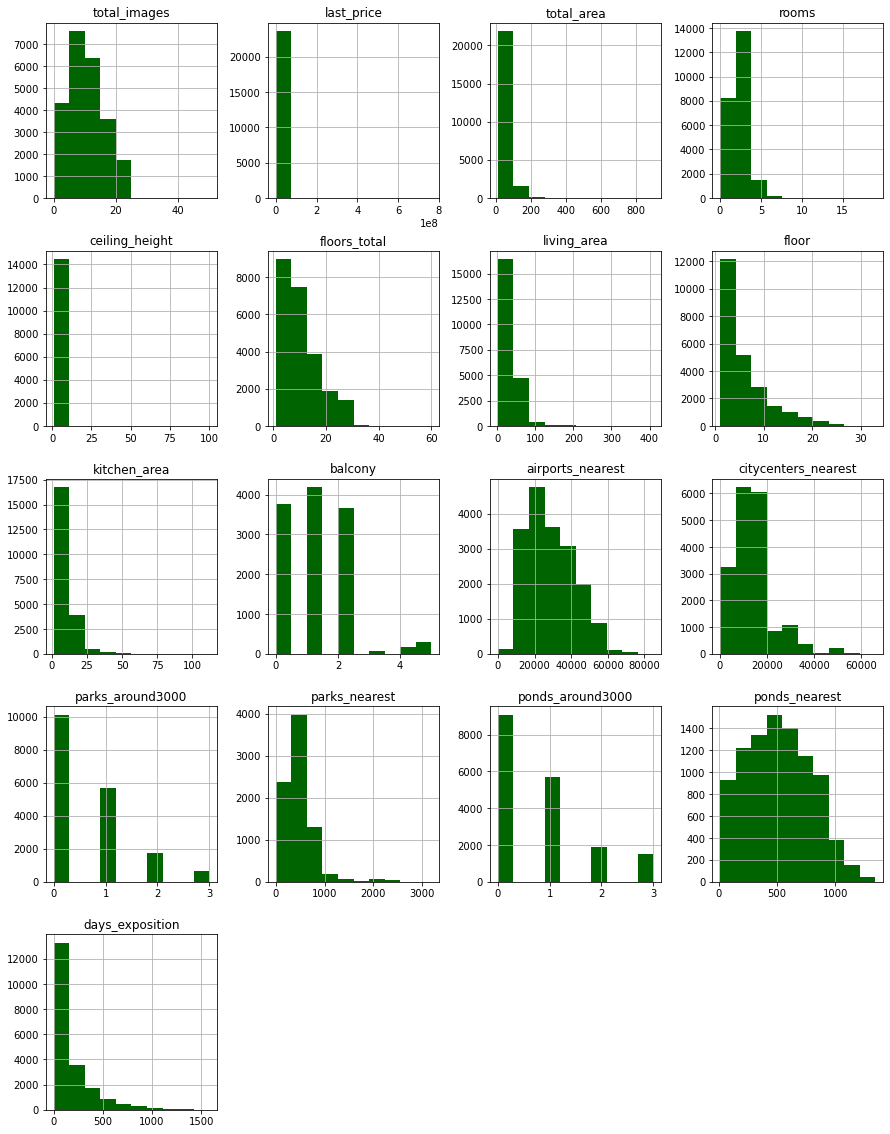

In [ ]:
# при построении гистограммы используем параметры цвета и размера
df.hist(figsize=(15, 20), color='DarkGreen')
pass

**Вывод:**
Изучив общую информацию датасета можем заметить, что некоторые значения имеют неправильный тип данных. Например, столбец `first_day_exposition` не является нужным нам типом даты `datetime` для последующего извлечения дня и месяца, а число балконов `balcony` не является целочисленным значением. Также `is_apartment` — апартаменты имеет тип объекта, а исходя из исходного описания нашего датасета он должен принимать булевы значения.    
С помощью метода `isna()` мы видим что наш датасет имеет большое количество пропусков в данных в 14 столбцах. Это может оказать негативное влияние на анализ данных и визуализацию. Ниже мы приступим к их обработке. 
Применив метод `describe()` к исходной таблице с данными мы также можем наблюдать выбросы в некоторых категориях данных. Так, в столбце `rooms` есть значения с числом комнат равных 19, а `balcony` имеет 5 балконов. Обратив внимание на цену публикации, также можно заметить сильно отклоняющиеся величины с ценой объектов в 763 млн. руб. Все эти выбросы могут повлиять на наш анализ данных, тем самым необходимо провести соответствующую предобработку.

### Предобработка данных

#### Найдем и изучим пропущенные значения в столбцах, отсортировав значения по убыванию:


In [ ]:
df.isna().sum().sort_values(ascending=False)

is_apartment            20924
parks_nearest           15620
ponds_nearest           14589
balcony                 11519
ceiling_height           9195
airports_nearest         5542
citycenters_nearest      5519
ponds_around3000         5518
parks_around3000         5518
days_exposition          3181
kitchen_area             2278
living_area              1903
floors_total               86
locality_name              49
total_images                0
last_price                  0
studio                      0
floor                       0
rooms                       0
first_day_exposition        0
total_area                  0
open_plan                   0
dtype: int64

#### Визуализируем долю пропусков по столбцам нашего датасета:

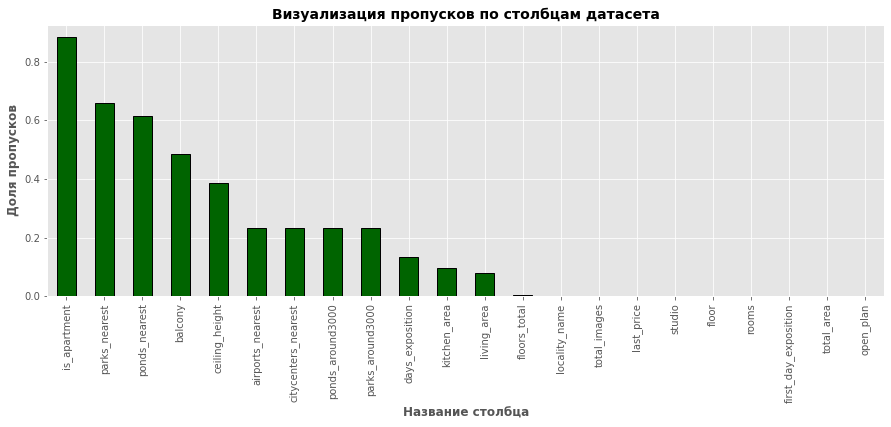

In [ ]:
# используем удобный для визуалиции стиль и настроим параметры сетки, цвета и размера шрифта
plt.style.use('ggplot')

# среднее пропущенных значений с сортировкой по убыванию
df.isna().mean().sort_values(ascending=False).plot(
    kind='bar', figsize=(15,5), 
    grid=True, color='DarkGreen', 
    edgecolor='black', linewidth=1,
)
plt.title('Визуализация пропусков по столбцам датасета',fontsize=14, fontweight="bold")
plt.xlabel('Название столбца',fontweight="bold")
plt.ylabel('Доля пропусков', fontweight="bold")
plt.show()

#### Столбец `is_apartment`

In [ ]:
# подсчитаем количество пропусков
print('Количество пропусков в столбце "is_apartment":', df['is_apartment'].isna().sum())
df['is_apartment'].value_counts()

Количество пропусков в столбце "is_apartment": 20924


False    2725
True       50
Name: is_apartment, dtype: int64

Столбец `is_apartment` в нашем анализе данных не используется, поэтому заменим пропуски на значения False. Пропуски могли появиться при умышленном неверном вводе данных о типах жилой площади. Так в апартаментах нельзя оформить постоянную регистрацию и налоговые вычеты, они отличаются высокими налогами на имущество, коммунальными и эксплуатационными расходами. При покупке апартаментов не удастся использовать материнский капитал. 

#### Столбцы `parks_nearest`, `ponds_nearest`, `parks_around3000`, `ponds_around3000`, `airports_nearest`

In [ ]:
print('Доля пропусков по столбцу "parks_nearest": {:.2%}'.format(df['parks_nearest'].isna().mean()))
print('Доля пропусков по столбцу "ponds_nearest": {:.2%}'.format(df['ponds_nearest'].isna().mean()))
print('Доля пропусков по столбцу "parks_around3000": {:.2%}'.format(df['parks_around3000'].isna().mean()))
print('Доля пропусков по столбцу "ponds_around3000": {:.2%}'.format(df['ponds_around3000'].isna().mean()))
print('Доля пропусков по столбцу "airports_nearest": {:.2%}'.format(df['airports_nearest'].isna().mean()))

Доля пропусков по столбцу "parks_nearest": 65.91%
Доля пропусков по столбцу "ponds_nearest": 61.56%
Доля пропусков по столбцу "parks_around3000": 23.28%
Доля пропусков по столбцу "ponds_around3000": 23.28%
Доля пропусков по столбцу "airports_nearest": 23.38%


Данные из указанных столбцов не используются в нашем анализе. Нам не предстоит определять взаимосвязь цены объекта и скорости продажи от этих характеристик, поэтому необходимости заменять пропущенные значения нет. При необходимости восстановить пропущенные значения можно было бы воспользовавшись локацией объекта на карте. Предположительно эти данные заполнялись системой автоматически, с чем может быть связано большое количество пропусков. Также не исключен и человеческий фактор. 

#### Столбец `balcony`

In [ ]:
print('Доля пропусков по столбцу "balcony": {:.2%}'.format(df['balcony'].isna().mean()))
df['balcony'].value_counts()

Доля пропусков по столбцу "balcony": 48.61%


1.00    4195
0.00    3758
2.00    3659
5.00     304
4.00     183
3.00      81
Name: balcony, dtype: int64

Можно предположить, что если данных о балконе нет, значит ответ о наличии балкона не давался. Соответственно, в этом случае можно заменить пропуски на 0 значения. Балкон является важной характеристикой при продаже недвижимости, поэтому отсутствие в данных данной величины скорее всего указывет на физическое отсутствие балкона у объекта недвижимости.

#### Столбец `ceiling_height`

In [ ]:
print('Доля пропусков по столбцу "ceiling_height": {:.2%}'.format(df['ceiling_height'].isna().mean()))

Доля пропусков по столбцу "ceiling_height": 38.80%


Данный столбец необходим нам для проведения анализа данных. Выше, с помощью метода describe() мы выяснили, что в данном столбце есть выбросы - потолки высотой 1.00 метр и 100 метров. Найдём среднее и медианное значение по столбцу.

In [ ]:
print(df['ceiling_height'].mean())
print(df['ceiling_height'].median())

2.7714988968559835
2.65


Далее, мы заменим пропуски в данных высоты потолков на медианное значение, так как оно соответствует минимальным значениям высоты потолков прописаных в СП 54.13330.2016 «СНиП 31-01-2003 Здания жилые многоквартирные». Будем считать, что пропуски появились случайно.

#### Столбец `days_exposition`

In [ ]:
print('Доля пропусков по столбцу "days_exposition": {:.2%}'.format(df['days_exposition'].isna().mean()))

Доля пропусков по столбцу "days_exposition": 13.42%


Количество дней размещения объявления (от публикации до снятия) необходим нам для выполнения анализа. Восстановить данные в пропусках каким-либо образом мы не сможем. Пропуски данных в столбце могут указывать на то, что объект недвижимости находится в процессе продажи и, соответственно, объявление не было снято. Процент пропусков достаточно значительный (13%) , поэтому оставим пропущенные значения как есть, чтобы избежать искажений в процессе анализа.

#### Столбцы `kitchen_area`, `living_area`

In [ ]:
print('Доля пропусков по столбцу "kitchen_area": {:.2%}'.format(df['kitchen_area'].isna().mean()))
print('Доля пропусков по столбцу "living_area": {:.2%}'.format(df['living_area'].isna().mean()))

Доля пропусков по столбцу "kitchen_area": 9.61%
Доля пропусков по столбцу "living_area": 8.03%


Значеня в данных столбцах необходимы нам для проведения анализа и последующих выводов. Следовательно, попробуем заменить пропущенные значения следующим образом:

-Заменим пропущенные значения жилой площади объекта недвижимости как соотношением среднего значения жилой площади этого объекта к среднему общей площади, затем умножив найденное соотношение на общую площадь конкретного объекта.

-Заменим пропущенные значения площади кухни соотношением среднего значения площади кухни к среднему общей площади, затем умножив найденное соотношение на общую площадь конкретного объекта.

#### Столбец `floor_total`

In [ ]:
print('Доля пропусков по столбцу "floors_total": {:.2%}'.format(df['floors_total'].isna().mean()))

Доля пропусков по столбцу "floors_total": 0.36%


Доля пропусков данного столбца незначительна, тем самым существенного искажения при анализе данных не будет. Поэтому пропуски в данном столбце можем удалить.

#### Столбец `citycenters_nearest`

In [ ]:
print('Доля пропусков по столбцу "citycenters_nearest": {:.2%}'.format(df['citycenters_nearest'].isna().mean()))

Доля пропусков по столбцу "citycenters_nearest": 23.29%


Данные этого столбца важны для нашего анализа. Данные отсутствуют по неизвестным причинам. Могли бы восстановить по геопозиции, но данных в сете нет. При необходимости восстановить пропущенные значения можно бы было воспользовавшись локацией объекта на карте. Предположительно эти данные заполнялись системой автоматически, с чем может быть связано большое количество пропусков. Также не исключен и человеческий фактор. Заменим пропущенные значения в данном столбце на 0, исключив в будущем нулевые значения из анализа.

#### Столбец `locality_name`

In [ ]:
print('Доля пропусков по столбцу "locality_name": {:.2%}'.format(df['locality_name'].isna().mean()))

Доля пропусков по столбцу "locality_name": 0.21%


Данные этого столбца для нашего анализа не используются. Доля пропусков данного столбца незначительна. Заменим пропущенные значения название населённого пункта на "unknown".

#### Обработка пропусков

Исходя из анализа пропущенных значений выполненную в пп. 2.1-2.11, проведем необходимую замену пропусков с перезаписью нашего датасета. 

In [ ]:
# удалим пропуски в столбце с количеством этажей
df.dropna(subset=['floors_total'], inplace=True)


# находим медиану высоты потолков
ceiling_height_median = df['ceiling_height'].median()

# заменяем пропущенные значения жилой площади и площади кухни
living_ratio = df['living_area'].mean() / df['total_area'].mean()
kitchen_ratio = df['kitchen_area'].mean() / df['total_area'].mean()

df['living_area'].fillna(living_ratio * df['total_area'], inplace=True)
df['kitchen_area'].fillna(kitchen_ratio * df['total_area'], inplace=True)

# заполним пропущенные значения по интересующим нас столбцам с помощью словаря
values = {'is_apartment' : False, 'ceiling_height': ceiling_height_median, 
          'balcony': 0, 'locality_name': 'unknown', 'citycenters_nearest': 0}
df.fillna(value=values, inplace=True)

df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23613 non-null  int64  
 1   last_price            23613 non-null  float64
 2   total_area            23613 non-null  float64
 3   first_day_exposition  23613 non-null  object 
 4   rooms                 23613 non-null  int64  
 5   ceiling_height        23613 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           23613 non-null  float64
 8   floor                 23613 non-null  int64  
 9   is_apartment          23613 non-null  bool   
 10  studio                23613 non-null  bool   
 11  open_plan             23613 non-null  bool   
 12  kitchen_area          23613 non-null  float64
 13  balcony               23613 non-null  float64
 14  locality_name         23613 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,citycenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.00,108.00,2019-03-07T00:00:00,3,2.70,16.00,51.00,8,False,...,25.00,0.00,Санкт-Петербург,18863.00,16028.00,1.00,482.00,2.00,755.00,NaN
1,7,3350000.00,40.40,2018-12-04T00:00:00,1,2.65,11.00,18.60,1,False,...,11.00,2.00,посёлок Шушары,12817.00,18603.00,0.00,NaN,0.00,NaN,81.00
2,10,5196000.00,56.00,2015-08-20T00:00:00,2,2.65,5.00,34.30,4,False,...,8.30,0.00,Санкт-Петербург,21741.00,13933.00,1.00,90.00,2.00,574.00,558.00
3,0,64900000.00,159.00,2015-07-24T00:00:00,3,2.65,14.00,90.81,9,False,...,27.84,0.00,Санкт-Петербург,28098.00,6800.00,2.00,84.00,3.00,234.00,424.00
4,2,10000000.00,100.00,2018-06-19T00:00:00,2,3.03,14.00,32.00,13,False,...,41.00,0.00,Санкт-Петербург,31856.00,8098.00,2.00,112.00,1.00,48.00,121.00
5,10,2890000.00,30.40,2018-09-10T00:00:00,1,2.65,12.00,14.40,5,False,...,9.10,0.00,городской посёлок Янино-1,NaN,0.00,NaN,NaN,NaN,NaN,55.00
6,6,3700000.00,37.30,2017-11-02T00:00:00,1,2.65,26.00,10.60,6,False,...,14.40,1.00,посёлок Парголово,52996.00,19143.00,0.00,NaN,0.00,NaN,155.00
7,5,7915000.00,71.60,2019-04-18T00:00:00,2,2.65,24.00,40.89,22,False,...,18.90,2.00,Санкт-Петербург,23982.00,11634.00,0.00,NaN,0.00,NaN,NaN
8,20,2900000.00,33.16,2018-05-23T00:00:00,1,2.65,27.00,15.43,26,False,...,8.81,0.00,посёлок Мурино,NaN,0.00,NaN,NaN,NaN,NaN,189.00
9,18,5400000.00,61.00,2017-02-26T00:00:00,3,2.50,9.00,43.60,7,False,...,6.50,2.00,Санкт-Петербург,50898.00,15008.00,0.00,NaN,0.00,NaN,289.00


#### Замена значений

Исследуем столбцы, в которых нужно изменить тип данных и преобразуем тип данных в выбранных столбцах следующим образом:
    
- `last_price` - приведем к целочисленному значению `int`, для исключения копеек в цене.
- `total_area` - округлим до 1 знака после запятой, оставив тип данных `float`. Так как площадь принято считать до 1 знака.
- `first_day_exposition` - тип данных `object` заменим на `datetime`. Для работы со временем необходимо привести данные в формат `datetime` - это позволит нам получать интересующие нас параметры в будущем.
- `rooms` - приведем к целочисленному значению `int`. Количество комнат должны принимать целоечисленные значения
- `floors_total` - `object` заменим на `int`. Этаж должен принимать целые значения.
- `living_area` - округлим до 1 знака после запятой, и приведем к `float`. Площадь принято считать до 1 знака.
- `floor` - приведем к целочисленному значению `int`. Этаж принимает целые значения.
- `kitchen_area` - округлим до 1 знака после запятой, и приведем к `float`. Площадь принято считать до 1 знака.
- `balcony` - `object` заменим на `int`. Количество балконов всегда будет целым числом.
- `citycenters_nearest` - приведем к целочисленному значению `int`. Расстояние в метрах.
- `days_exposition` - `object` заменим на `int`. Так как это количество дней, целое число.







In [ ]:
df['last_price'] = df['last_price'].astype('int64')
df['living_area'] = df['living_area'].astype('float64').round(2)
df['total_area'] = df['living_area'].astype('float64').round(2)
df['kitchen_area'] = df['living_area'].astype('float64').round(2)
df['days_exposition'] = np.floor(pd.to_numeric(df['days_exposition'], errors='coerce')).astype(pd.Int64Dtype())
#df[col] = pd.to_numeric(df[col],errors='coerce').astype(pd.Int64Dtype())
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
df['rooms'] = df['rooms'].astype('int8')
df['floors_total'] = df['floors_total'].astype('int8')
df['balcony'] = df['balcony'].astype('int8')
df['citycenters_nearest'] = df['citycenters_nearest'].astype('int64')
df['floor'] = df['floor'].astype('int8')


df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23613 non-null  int64         
 1   last_price            23613 non-null  int64         
 2   total_area            23613 non-null  float64       
 3   first_day_exposition  23613 non-null  datetime64[ns]
 4   rooms                 23613 non-null  int8          
 5   ceiling_height        23613 non-null  float64       
 6   floors_total          23613 non-null  int8          
 7   living_area           23613 non-null  float64       
 8   floor                 23613 non-null  int8          
 9   is_apartment          23613 non-null  bool          
 10  studio                23613 non-null  bool          
 11  open_plan             23613 non-null  bool          
 12  kitchen_area          23613 non-null  float64       
 13  balcony         

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,citycenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000,51.00,2019-03-07,3,2.70,16,51.00,8,False,...,51.00,0,Санкт-Петербург,18863.00,16028,1.00,482.00,2.00,755.00,<NA>
1,7,3350000,18.60,2018-12-04,1,2.65,11,18.60,1,False,...,18.60,2,посёлок Шушары,12817.00,18603,0.00,NaN,0.00,NaN,81
2,10,5196000,34.30,2015-08-20,2,2.65,5,34.30,4,False,...,34.30,0,Санкт-Петербург,21741.00,13933,1.00,90.00,2.00,574.00,558
3,0,64900000,90.81,2015-07-24,3,2.65,14,90.81,9,False,...,90.81,0,Санкт-Петербург,28098.00,6800,2.00,84.00,3.00,234.00,424
4,2,10000000,32.00,2018-06-19,2,3.03,14,32.00,13,False,...,32.00,0,Санкт-Петербург,31856.00,8098,2.00,112.00,1.00,48.00,121


Вывод: Таким образом, мы выделили необходимые столбцы для анализа привели данные к нужному типу. Дальнейший анализ будем проводить с помощью диаграмм рассеивания и срезов, исключая аномальные значения.

In [ ]:
df.shape

(23613, 22)

#### Выведем список уникальных значений столбца 'locality_name' и устраним неявные дубликаты. 

In [ ]:
# для удобства визуализации выведем результат списком
sorted(df['locality_name'].unique().tolist())

['unknown',
 'Бокситогорск',
 'Волосово',
 'Волхов',
 'Всеволожск',
 'Выборг',
 'Высоцк',
 'Гатчина',
 'Зеленогорск',
 'Ивангород',
 'Каменногорск',
 'Кингисепп',
 'Кириши',
 'Кировск',
 'Колпино',
 'Коммунар',
 'Красное Село',
 'Кронштадт',
 'Кудрово',
 'Лодейное Поле',
 'Ломоносов',
 'Луга',
 'Любань',
 'Мурино',
 'Никольское',
 'Новая Ладога',
 'Отрадное',
 'Павловск',
 'Петергоф',
 'Пикалёво',
 'Подпорожье',
 'Приморск',
 'Приозерск',
 'Пушкин',
 'Санкт-Петербург',
 'Светогорск',
 'Сертолово',
 'Сестрорецк',
 'Сланцы',
 'Сосновый Бор',
 'Сясьстрой',
 'Тихвин',
 'Тосно',
 'Шлиссельбург',
 'городской поселок Большая Ижора',
 'городской поселок Янино-1',
 'городской посёлок Будогощь',
 'городской посёлок Виллози',
 'городской посёлок Лесогорский',
 'городской посёлок Мга',
 'городской посёлок Назия',
 'городской посёлок Новоселье',
 'городской посёлок Павлово',
 'городской посёлок Рощино',
 'городской посёлок Свирьстрой',
 'городской посёлок Советский',
 'городской посёлок Фёдоровское

In [ ]:
# получим длину списка по названиям населенных пунктов
len(df['locality_name'].unique())

365

Мы видим список состоящий из 331 значений. При анализе названий можно заметить, что «поселок Рябово» и «поселок городского типа Рябово», «поселок Тельмана» и «посёлок Тельмана» — это обозначения одних и тех же населённых пунктов. Можем заменить названия в существующем столбце устранив тем самым неявные дубликаты. Применим следующую логику:

In [ ]:
# с помощью регулярных выражений заменим следующие строки
df['locality_name'] = df['locality_name'].str.replace('ё', 'е', regex=True)
df['locality_name'] = df['locality_name'].str.replace('поселок городского типа ', 
'', regex=True).replace('городской поселок ', '', regex=True).replace('поселок при железнодорожной станции ', 
'', regex=True).replace('поселок станции ', '', regex=True).replace('коттеджный поселок ', 
'', regex=True).replace('деревня ', '', regex=True).replace('поселок ', 
'', regex=True).replace('село ', '', regex=True).replace('садоводческое некоммерческое товарищество ', 
'', regex=True).replace('садовое товарищество ', '', regex=True)

In [ ]:
# длина списка уникальных названий населенных пунктов сократилась
len(df['locality_name'].unique())

306

In [ ]:
# выведем отсортированный список ещё раз для проверки
sorted(df['locality_name'].unique().tolist())

['unknown',
 'Агалатово',
 'Александровская',
 'Алексеевка',
 'Аннино',
 'Аро',
 'Барышево',
 'Батово',
 'Бегуницы',
 'Белогорка',
 'Белоостров',
 'Бокситогорск',
 'Большая Вруда',
 'Большая Ижора',
 'Большая Пустомержа',
 'Большие Колпаны',
 'Большое Рейзино',
 'Большой Сабск',
 'Бор',
 'Борисова Грива',
 'Бугры',
 'Будогощь',
 'Ваганово',
 'Важины',
 'Вартемяги',
 'Вахнова Кара',
 'Вещево',
 'Виллози',
 'Вознесенье',
 'Возрождение',
 'Войсковицы',
 'Войскорово',
 'Володарское',
 'Волосово',
 'Волхов',
 'Всеволожск',
 'Выборг',
 'Вырица',
 'Выскатка',
 'Высокоключевой',
 'Высоцк',
 'Гаврилово',
 'Гарболово',
 'Гатчина',
 'Гладкое',
 'Глажево',
 'Глебычево',
 'Глинка',
 'Гончарово',
 'Горбунки',
 'Гостилицы',
 'Громово',
 'Дзержинского',
 'Дружная Горка',
 'Дружноселье',
 'Дубровка',
 'Елизаветино',
 'Ефимовский',
 'Жилгородок',
 'Жилпоселок',
 'Житково',
 'Заводской',
 'Заклинье',
 'Заневка',
 'Запорожское',
 'Зеленогорск',
 'Зимитицы',
 'Ивангород',
 'Извара',
 'Ильичево',
 'Иссад',


Тем самым нам удалось убрать 142 неявных дубликатов из столбца `locality_name`.

#### Найдем и устраним редкие и выбивающиеся значения (аномалии) в столбцах, который будут нужны для анализа.

- Столбец `last_price` проанализируем на присутствие редких и выбивающихся значений. Уберем квартиры со слишком высокой стоимостью, а также квартиры со стоимостью ниже 300,000 рублей применяя метод `drop`. Квартир с нулевой стоимостью в нашей выборке нет.

In [ ]:
# сделаем выборку используя метод query c нужным условием и напечатаем результат на экране
print('Квартир стоимостью 0 руб:', df.query('last_price == 0')['last_price'].count())
print('Квартир стоимостью меньше 200.000 руб:', df.query('last_price < 200000')['last_price'].count())
print('Квартир стоимостью больше 200.000 руб:', df.query('last_price > 200000')['last_price'].count())
print('Квартир стоимостью больше 100.000.000 руб:', df.query('last_price > 100000000')['last_price'].count())

Квартир стоимостью 0 руб: 0
Квартир стоимостью меньше 200.000 руб: 1
Квартир стоимостью больше 200.000 руб: 23612
Квартир стоимостью больше 100.000.000 руб: 37


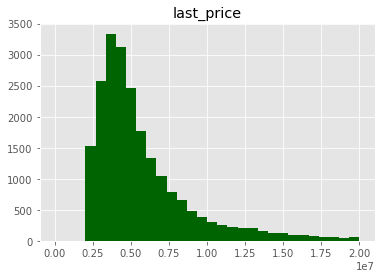

In [ ]:
#удаляем выбивающиеся значения
df.drop(index=df.query('last_price > 100000000').index, inplace=True)
df.drop(index=df.query('last_price < 2000000').index, inplace=True)

# для наглядности распределения значений после обработки построим гистограмму
df.hist('last_price', bins=30, range=(0,20000000), color='DarkGreen');

- Столбец `total_area` не содержит квартир с общей площадью менее 10 кв.м.; несмотря на это присутствуют значения с общей площадью меньше 20 кв.м. Данные значения не будем считать аномальными. Объекты недвижимости c общей площадью более 500 кв.м. могут считаться выбивающимися значениями. Их немного и поэтому лучше удалить.

In [ ]:
# сделаем выборку используя метод query c нужным условием и напечатаем результат на экране
print('Квартир c площадью менее 20 кв.м.:',df.query('total_area < 20')['total_area'].count()) 
print('Квартир c площадью более 500 кв.м.:',df.query('total_area > 500')['total_area'].count())

Квартир c площадью менее 20 кв.м.: 5900
Квартир c площадью более 500 кв.м.: 0


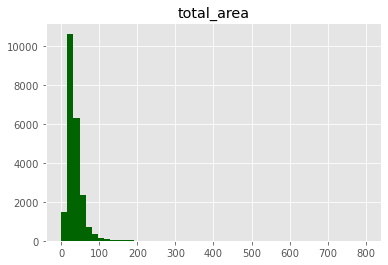

In [ ]:
#удаляем аномальные значения
df.drop(index=df.query('total_area > 500').index,inplace=True)

# для наглядности распределения значений после обработки построим гистограмму
df.hist('total_area', bins=50, range=(0,800), color='DarkGreen');

- Столбец `rooms` содержит объекты недвижимости с 10+ комнатами. Таких значений немного, они могут быть признананы выбивающимися значениями, поэтому их лучше удалить.

In [ ]:
# сделаем выборку используя метод query c нужным условием и напечатаем результат на экране
print('Квартиры с 7 комнатами и более:',df.query('rooms > 7')['rooms'].count())

Квартиры с 7 комнатами и более: 28


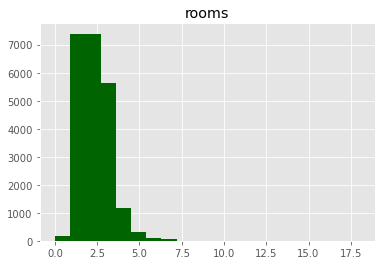

In [ ]:
#удаляем выбивающиеся значения
df.drop(index=df.query('rooms > 7').index, inplace=True)

# для наглядности распределения значений после обработки построим гистограмму
df.hist('rooms', bins=20, range=(0,18), color='DarkGreen');

- Столбец `ceiling_height` содержит данные о высоте потолков в объектах недвижимости. Как было замечено ранее в пункте 2.6, высота потолков устанавливается с учетом минимальных требований установленных СНиП. Независимо от года постройки и от типа здания, высота от пола до потолка должна быть в пределах 2.5-3.2 метров. Например, где указана высота потолков 25 м и 32 м, логично предположить, что на самом деле это вещественные значения: 2.5 м и 3.2 м соответственно. Также есть одно значение, которое показывает высоту потолков выше 50м и несколько значений где высота меньше 2м. 


In [ ]:
# сделаем выборку используя метод query c нужным условием и напечатаем результат на экране
print('Квартир с потолками меньше 2м: ' + str(df.query('ceiling_height <= 2')['ceiling_height'].count()))
print('Квартир с потолками от 2 до 4м: ' + str(df.query('ceiling_height > 2 and ceiling_height <= 4')['ceiling_height'].count()))
print('Квартир с потолками от 4 до 25м: ' + str(df.query('ceiling_height > 4 and ceiling_height < 25')['ceiling_height'].count()))
print('Квартир с потолками от 25м до 32м: ' + str(df.query('ceiling_height >= 25 and ceiling_height <= 32')['ceiling_height'].count()))
print('Квартир с потолками от 33м до 50м: ' + str(df.query('ceiling_height > 32 and ceiling_height < 50')['ceiling_height'].count()))
print('Квартир с потолками от 50м: ' + str(df.query('ceiling_height >= 50')['ceiling_height'].count()))

Квартир с потолками меньше 2м: 10
Квартир с потолками от 2 до 4м: 22099
Квартир с потолками от 4 до 25м: 49
Квартир с потолками от 25м до 32м: 17
Квартир с потолками от 33м до 50м: 0
Квартир с потолками от 50м: 1


Сначала удалим значения где высота потолков от 4 до 25 метров. Для квартир с высотой потолков до 25 до 32 метров предполагаем что произшла опечатка при вводе данных, разделив соответственные значения на 10. Удаляем значения с высотой потолков более 32 метров и менее 2 метров.

In [ ]:
#удаляем аномальные значения применяя логику
df.drop(index=df.query('ceiling_height > 4 and ceiling_height < 25').index,inplace=True)

df.update(df[(df['ceiling_height'] >= 25) & (df['ceiling_height'] <= 32)]['ceiling_height']/10)

df.drop(index=df.query('ceiling_height > 32').index,inplace=True)
df.drop(index=df.query('ceiling_height <= 2').index,inplace=True)

- Столбец `living_area` имеет значения с жилой площадью меньше 10 кв.м. Удалим данные аномалии.

In [ ]:
# сделаем выборку используя метод query c нужным условием и напечатаем результат на экране
print('Жилая площадь меньше 10 кв.м.: ',df.query('living_area < 10')['living_area'].count())
print('Жилая площадь больше общей площади: ',df.query('living_area > total_area')['living_area'].count())

Жилая площадь меньше 10 кв.м.:  26
Жилая площадь больше общей площади:  0


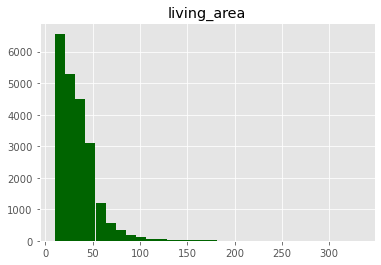

In [ ]:
#удаляем выбивающиеся значения
df.drop(index=df.query('living_area < 10').index,inplace=True)

# для наглядности распределения значений после обработки построим гистограмму
df.hist('living_area', bins=30, color='DarkGreen');

- Столбец `kitchen_area` - площадь кухни. Есть значения с площадью кухни меньше 2 кв. метров. Удалим данные строки.

In [ ]:
# сделаем выборку используя метод query c нужным условием и напечатаем результат на экране
print('Площадь кухни меньше 2 кв.м.: ', df.query('kitchen_area < 2')['living_area'].count())
print('Площадь кухни больше общей: ', df.query('kitchen_area > total_area')['living_area'].count())

Площадь кухни меньше 2 кв.м.:  0
Площадь кухни больше общей:  0


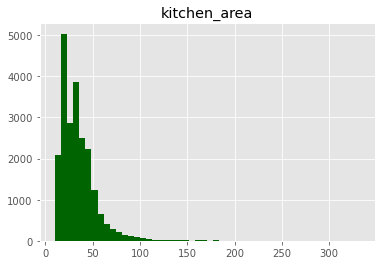

In [ ]:
#удаляем аномальные значения
df.drop(index=df.query('kitchen_area < 2').index,inplace=True)

# для наглядности распределения значений после обработки построим гистограмму
df.hist('kitchen_area', bins=50, color='DarkGreen');

Сбросим индексацию после обработки аномалий. Выведем минимальные и максимальные значения в столбцах где мы обработали аномалии в данных.

In [ ]:
df.reset_index(drop=True, inplace=True)

(
    df[['rooms', 'total_area', 'ceiling_height', 'last_price', 'living_area',  'kitchen_area']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,last_price,living_area,kitchen_area
count,"22,090.00","22,090.00","22,090.00","22,090.00","22,090.00","22,090.00"
min,0.00,10.00,2.25,"2,000,000.00",10.00,10.00
max,7.00,332.00,4.00,"99,000,000.00",332.00,332.00


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22090 entries, 0 to 22089
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22090 non-null  int64         
 1   last_price            22090 non-null  int64         
 2   total_area            22090 non-null  float64       
 3   first_day_exposition  22090 non-null  datetime64[ns]
 4   rooms                 22090 non-null  int8          
 5   ceiling_height        22090 non-null  float64       
 6   floors_total          22090 non-null  int8          
 7   living_area           22090 non-null  float64       
 8   floor                 22090 non-null  int8          
 9   is_apartment          22090 non-null  bool          
 10  studio                22090 non-null  bool          
 11  open_plan             22090 non-null  bool          
 12  kitchen_area          22090 non-null  float64       
 13  balcony         

### Рассчет и добавление в таблицу дополнительных параметров

#### Добавим столбец `price_per_m2` показывающий цену за квадратный метр

In [ ]:
# вычисляем цену как отношение цены объекта к общей площади объекта
df['price_per_m2'] = round(df['last_price'] / df['total_area'], 1)

# выведем первые 5 строк таблицы
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,citycenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_m2
0,20,13000000,51.00,2019-03-07,3,2.70,16,51.00,8,False,...,0,Санкт-Петербург,18863.00,16028,1.00,482.00,2.00,755.00,<NA>,254902.00
1,7,3350000,18.60,2018-12-04,1,2.65,11,18.60,1,False,...,2,Шушары,12817.00,18603,0.00,NaN,0.00,NaN,81,180107.50
2,10,5196000,34.30,2015-08-20,2,2.65,5,34.30,4,False,...,0,Санкт-Петербург,21741.00,13933,1.00,90.00,2.00,574.00,558,151486.90
3,0,64900000,90.81,2015-07-24,3,2.65,14,90.81,9,False,...,0,Санкт-Петербург,28098.00,6800,2.00,84.00,3.00,234.00,424,714679.00
4,2,10000000,32.00,2018-06-19,2,3.03,14,32.00,13,False,...,0,Санкт-Петербург,31856.00,8098,2.00,112.00,1.00,48.00,121,312500.00


#### День недели, месяц и год публикации объявления

In [ ]:
# приведем дни недели к обозначением цифрами, 0 для понедельника и 6 для воскресенья, соответственно
df['month'] = df['first_day_exposition'].dt.month
df['year'] = df['first_day_exposition'].dt.year
df['day'] = df['first_day_exposition'].dt.weekday

# сделаем более удобный вид используя словарь

dict_weekdays = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 
                    4: 'Fri', 5: 'Sat', 6: 'Sun'}
#dict_month = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 
                   # 5: 'May', 6: 'Jun', 7: 'Jul',
            # 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 
                  #  12: 'Dec'}
df['day'] = df['day'].map(dict_weekdays)
# df['month'] = df['month'].map(dict_month)
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,citycenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_m2,month,year,day
0,20,13000000,51.00,2019-03-07,3,2.70,16,51.00,8,False,...,16028,1.00,482.00,2.00,755.00,<NA>,254902.00,3,2019,Thu
1,7,3350000,18.60,2018-12-04,1,2.65,11,18.60,1,False,...,18603,0.00,NaN,0.00,NaN,81,180107.50,12,2018,Tue
2,10,5196000,34.30,2015-08-20,2,2.65,5,34.30,4,False,...,13933,1.00,90.00,2.00,574.00,558,151486.90,8,2015,Thu
3,0,64900000,90.81,2015-07-24,3,2.65,14,90.81,9,False,...,6800,2.00,84.00,3.00,234.00,424,714679.00,7,2015,Fri
4,2,10000000,32.00,2018-06-19,2,3.03,14,32.00,13,False,...,8098,2.00,112.00,1.00,48.00,121,312500.00,6,2018,Tue


#### Категоризация типа этажа. 

In [ ]:
# замену значения этажа на категориальное реализуем через .where()
df['floor_cat'] = np.where(df['floor'] == 1, 'первый', 'другой')
df['floor_cat'] = np.where(df['floor'] == df['floors_total'], 
                                     'последний', df['floor_cat']
                                    )

df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_m2,month,year,day,floor_cat
0,20,13000000,51.00,2019-03-07,3,2.70,16,51.00,8,False,...,1.00,482.00,2.00,755.00,<NA>,254902.00,3,2019,Thu,другой
1,7,3350000,18.60,2018-12-04,1,2.65,11,18.60,1,False,...,0.00,NaN,0.00,NaN,81,180107.50,12,2018,Tue,первый
2,10,5196000,34.30,2015-08-20,2,2.65,5,34.30,4,False,...,1.00,90.00,2.00,574.00,558,151486.90,8,2015,Thu,другой
3,0,64900000,90.81,2015-07-24,3,2.65,14,90.81,9,False,...,2.00,84.00,3.00,234.00,424,714679.00,7,2015,Fri,другой
4,2,10000000,32.00,2018-06-19,2,3.03,14,32.00,13,False,...,2.00,112.00,1.00,48.00,121,312500.00,6,2018,Tue,другой


#### Расстояние до центра города в километрах

In [ ]:
# переведем значения из м в км и округлим до целых значений
df['km_to_citycenters'] = round(df['citycenters_nearest'] / 1000)

# приведем к целочисленному формату
df['km_to_citycenters'] = df['km_to_citycenters'].astype('int32')

df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_m2,month,year,day,floor_cat,km_to_citycenters
0,20,13000000,51.00,2019-03-07,3,2.70,16,51.00,8,False,...,482.00,2.00,755.00,<NA>,254902.00,3,2019,Thu,другой,16
1,7,3350000,18.60,2018-12-04,1,2.65,11,18.60,1,False,...,NaN,0.00,NaN,81,180107.50,12,2018,Tue,первый,19
2,10,5196000,34.30,2015-08-20,2,2.65,5,34.30,4,False,...,90.00,2.00,574.00,558,151486.90,8,2015,Thu,другой,14
3,0,64900000,90.81,2015-07-24,3,2.65,14,90.81,9,False,...,84.00,3.00,234.00,424,714679.00,7,2015,Fri,другой,7
4,2,10000000,32.00,2018-06-19,2,3.03,14,32.00,13,False,...,112.00,1.00,48.00,121,312500.00,6,2018,Tue,другой,8


**Вывод** Мы получили готовый к анализу датасет включив в него дополнительные параметры, исключенив аномалии, повторы и пропуски в данных. 

### Проведем исследовательский анализ данных (EDA)

#### Изучим следующие параметры объектов построив гистограмму для кажого:

- `total_area` общая площадь объекта

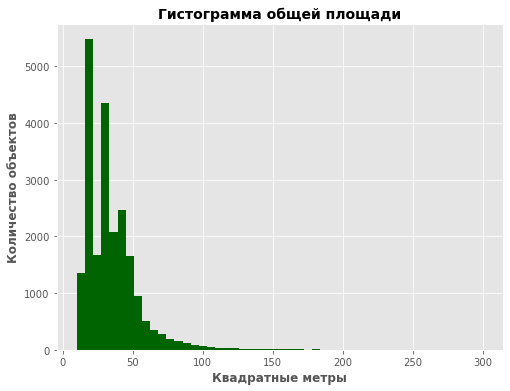

In [ ]:
# построим гистограмму
plt.style.use('ggplot')

plt.figure(figsize=(8, 6))
plt.hist(df['total_area'], bins=50, range=(10,300), color='DarkGreen')
plt.title('Гистограмма общей площади', fontsize=14, fontweight="bold")
plt.xlabel('Квадратные метры', fontweight="bold")
plt.ylabel('Количество объектов', fontweight="bold")
plt.show()

Гисторграмма отображает очень малое количество объектов с общей площадью более 200 кв.м. Чаще всего встречаются объекты с общей площадью 30-80 кв.м. Гистограмма имеет распределение с обрывом слева. Если построить диаграмму размаха будет немного значений которые окажутся выбросами, можно предположить что это элитная недвижимость площадь которой сильно отличается.

- `total_area` жилая площадь

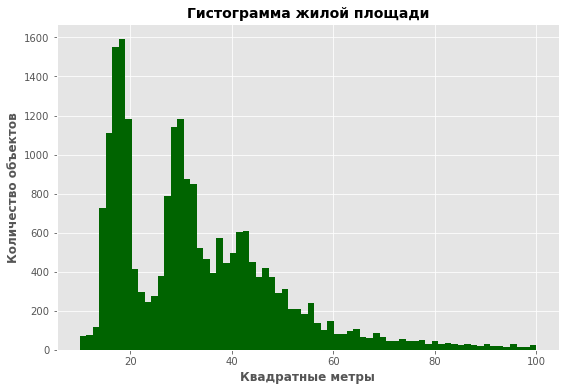

In [ ]:
plt.style.use('ggplot')

plt.figure(figsize=(9, 6))
plt.hist(df['living_area'], bins=70, range=(10, 100), color='DarkGreen')
plt.title('Гистограмма жилой площади', fontsize=14, fontweight="bold")
plt.xlabel('Квадратные метры', fontweight="bold")
plt.ylabel('Количество объектов', fontweight="bold")
plt.show()

Наблюдаем двухпиковое (бимодальное распределение) на нашей гисторграмме. Наибольшее количество объектов из наших данных собрано на интервалах соответствующих жилой площади 10-20 кв.м. и на интервалах 28-36 кв.м. Два пика графика могли быть вызваны различиями в распредением жилой площади для 1-комнатных, 2-комнатных и многокомнатных жилых объектов соответственно.

- `kitchen_area` площадь кухни

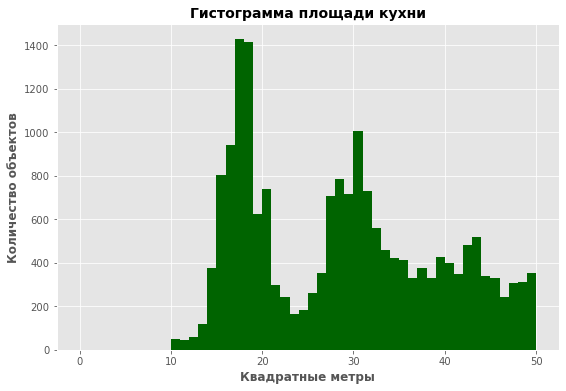

In [ ]:
plt.style.use('ggplot')

plt.figure(figsize=(9, 6))
plt.hist(df['kitchen_area'], bins=50, range=(0, 50), color='DarkGreen')
plt.title('Гистограмма площади кухни', fontsize=14, fontweight="bold")
plt.xlabel('Квадратные метры', fontweight="bold")
plt.ylabel('Количество объектов', fontweight="bold")
plt.show()

На гистограмме наблюдаем распределение величин скошенное вправо. Основное количество объектов соосредоточено в интервалах соответсвующих площади кухонь 5-15 кв.м. Кухням с площадью 32 кв.м. и более соответсвует малое количество объектов нашего датасета.

- `rooms` количество комнат

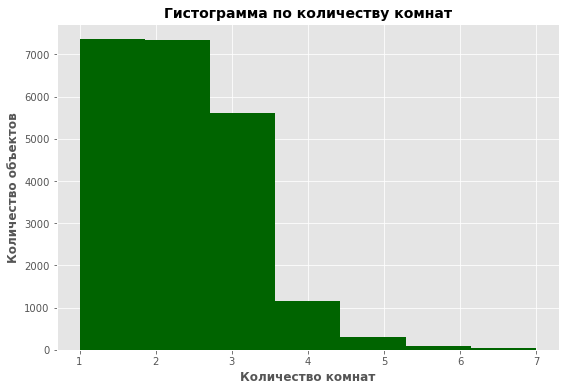

In [ ]:
plt.style.use('ggplot')

plt.figure(figsize=(9, 6))
plt.hist(df['rooms'], bins=7, range=(1, 7), color='DarkGreen')
plt.title('Гистограмма по количеству комнат', fontsize=14, fontweight="bold")
plt.xlabel('Количество комнат', fontweight="bold")
plt.ylabel('Количество объектов', fontweight="bold")
plt.show()

На гистограмме наблюдаем распределение величин скошенное вправо. Больше всего значений датасета сосредоточены на 1-комнатных, 2-комнатных и 3-комнатных объктах недвижимости, но встречаются и редкие исключения, такие как 6-ти и 7-комнатные объекты.

- `ceiling_height` высота потолков

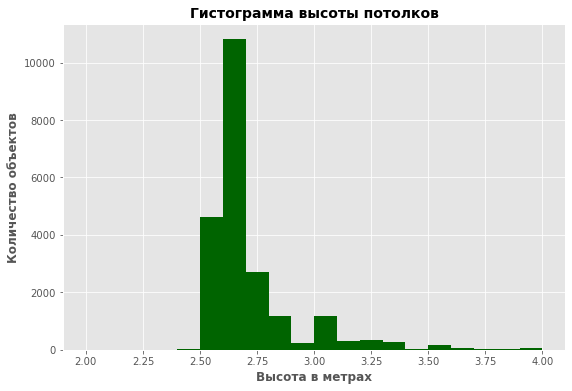

In [ ]:
plt.style.use('ggplot')

plt.figure(figsize=(9, 6))
plt.hist(df['ceiling_height'], bins=20, range=(2, 4), color='DarkGreen')
plt.title('Гистограмма высоты потолков', fontsize=14, fontweight="bold")
plt.xlabel('Высота в метрах', fontweight="bold")
plt.ylabel('Количество объектов', fontweight="bold")
plt.show()

На гистограмме наблюдаем два пика 2.5 м и 2.7 м, что соответсвует логике минимальных требований установленных в СНиП для высоты жилых помещений.  

- `floor` этаж квартиры

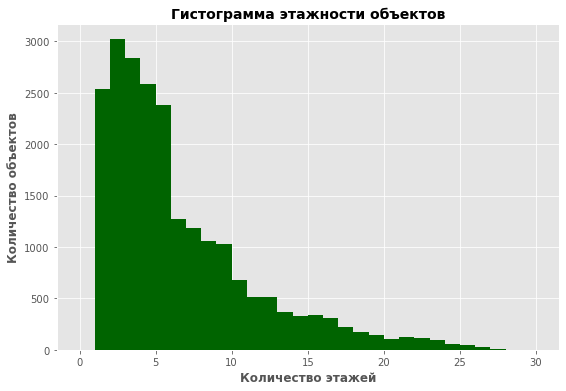

In [ ]:
plt.style.use('ggplot')

plt.figure(figsize=(9, 6))
plt.hist(df['floor'], bins=30, range=(0, 30), color='DarkGreen')
plt.title('Гистограмма этажности объектов', fontsize=14, fontweight="bold")
plt.xlabel('Количество этажей', fontweight="bold")
plt.ylabel('Количество объектов', fontweight="bold")
plt.show()

На гистограмме наблюдается распределение величин скошенное вправо. В нашем датасете больше всего объектов с расположением на 1 по 6 этажах.

- `floor` тип этажа квартиры («первый», «последний», «другой»)

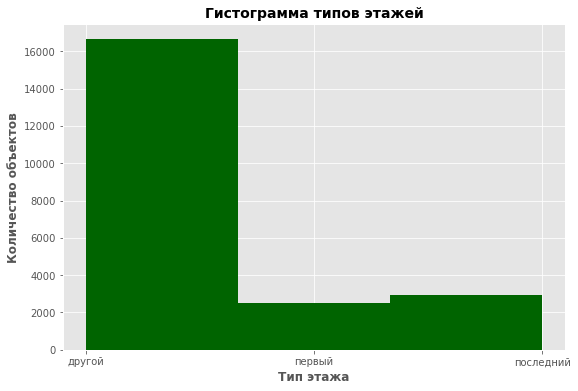

In [ ]:
plt.style.use('ggplot')

plt.figure(figsize=(9, 6))
plt.hist(df['floor_cat'], bins=3, color='DarkGreen')
plt.title('Гистограмма типов этажей', fontsize=14, fontweight="bold")
plt.xlabel('Тип этажа', fontweight="bold")
plt.ylabel('Количество объектов', fontweight="bold")
plt.show()

Исходя из гистограммы можно заметить, что основное количество объектов недвижимости сосредоточено в категории "Другой" этаж. Объектов недвижимости расположенных на первых и последних этажах гораздо меньше.

- `floors_total` общее количество этажей в доме

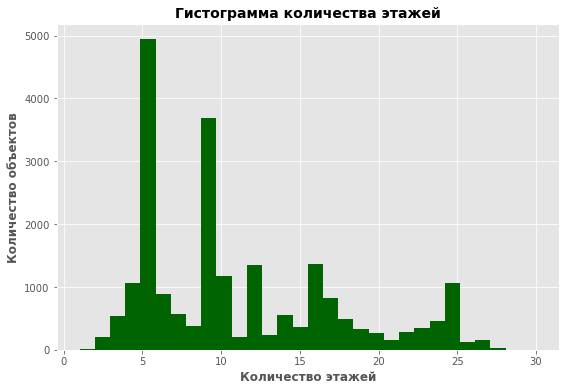

In [ ]:
plt.style.use('ggplot')

plt.figure(figsize=(9, 6))
plt.hist(df['floors_total'], bins=30, range=(1, 30), color='DarkGreen')
plt.title('Гистограмма количества этажей', fontsize=14, fontweight="bold")
plt.xlabel('Количество этажей', fontweight="bold")
plt.ylabel('Количество объектов', fontweight="bold")
plt.show()

Наблюдаем мультимодальное распределение значений с несколькими пиками на следующих объектах недвижимости: 5-этажные объекты, 9-этажные объекты, и присутствие небольших пиковых значений у многоэтажных объектов.

- `citycenters_nearest` расстояние до центра города в метрах

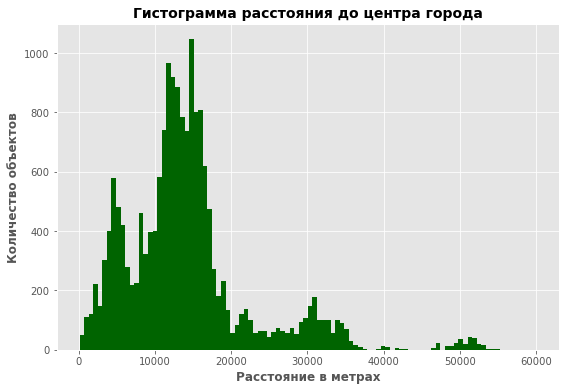

In [ ]:
plt.style.use('ggplot')

plt.figure(figsize=(9, 6))
plt.hist(df['citycenters_nearest'], bins=100, range=(100, 60000), color='DarkGreen')
plt.title('Гистограмма расстояния до центра города', fontsize=14, fontweight="bold")
plt.xlabel('Расстояние в метрах', fontweight="bold")
plt.ylabel('Количество объектов', fontweight="bold")
plt.show()

Исходя из гистограммы, наблюдаем двухпиковое (бимодальное распределение значений). Большее количество объектов нашего датасета находится на расстояниях, 4-6км и 12-17 км до центра города.

- `airport_nearest` расстояние до ближайшего аэропорта

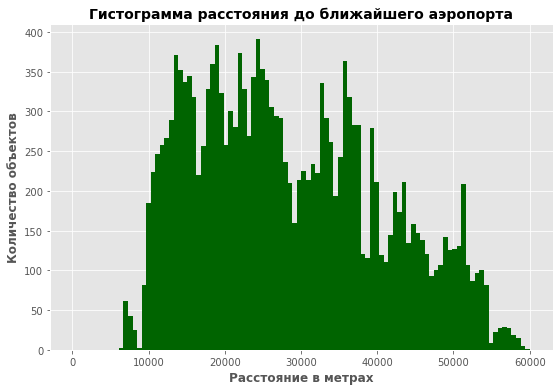

In [ ]:
plt.style.use('ggplot')

plt.figure(figsize=(9, 6))
plt.hist(df['airports_nearest'], bins=100, range=(100, 60000), color='DarkGreen')
plt.title('Гистограмма расстояния до ближайшего аэропорта', fontsize=14, fontweight="bold")
plt.xlabel('Расстояние в метрах', fontweight="bold")
plt.ylabel('Количество объектов', fontweight="bold")
plt.show()

Гистограмма имеет вид "гребенки". Большинство значений датасета сосредоточено на расстоянии 10 км от аэропорта и более. Присутствуют 2 изолированных распределения с расстояниями до ближайшего аэропорта меньше 10 км и более 55 км. Таких данных в датасете мало, поэтому они не показательны.

- `park_nearest` расстояние до ближайшего парка

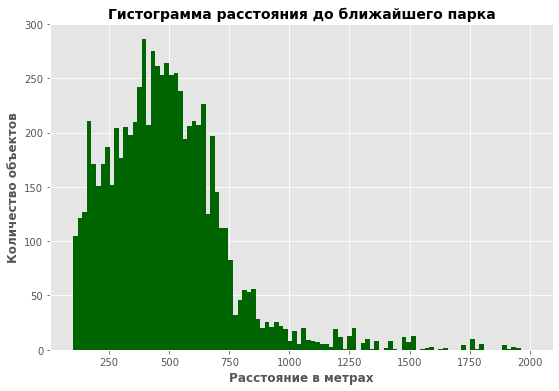

In [ ]:
plt.style.use('ggplot')

plt.figure(figsize=(9, 6))
plt.hist(df['parks_nearest'], bins=100, range=(100, 2000), color='DarkGreen')
plt.title('Гистограмма расстояния до ближайшего парка', fontsize=14, fontweight="bold")
plt.xlabel('Расстояние в метрах', fontweight="bold")
plt.ylabel('Количество объектов', fontweight="bold")
plt.show()

На гистограмме наблюдается распределение величин скошенное вправо. В нашем датасете больше всего объектов с расположением на расстоянии 250-750 м до ближайшего парка.

- `day`, `month` день и месяц публикации объявления

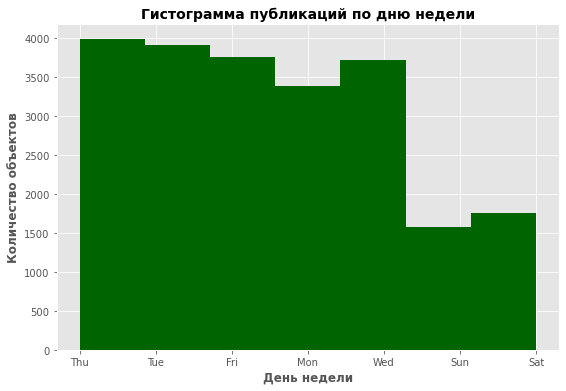

In [ ]:
plt.style.use('ggplot')

plt.figure(figsize=(9, 6))
plt.hist(df['day'], bins=7, color='DarkGreen')
plt.title('Гистограмма публикаций по дню недели', fontsize=14, fontweight="bold")
plt.xlabel('День недели', fontweight="bold")
plt.ylabel('Количество объектов', fontweight="bold")
plt.show()

Из гистограммы видим что количество публикаций в выходные дни почти в два раза меньше чем в будние дни. Видимо и риэлторы тоже отдыхают!

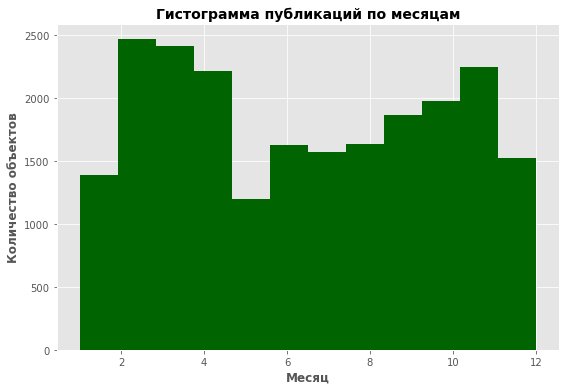

In [ ]:
plt.style.use('ggplot')

plt.figure(figsize=(9, 6))
plt.hist(df['month'], bins=12, color='DarkGreen')
plt.title('Гистограмма публикаций по месяцам', fontsize=14, fontweight="bold")
plt.xlabel('Месяц', fontweight="bold")
plt.ylabel('Количество объектов', fontweight="bold")
plt.show()

Март и Май - месяцы с наибольшим количеством публикаций, а Апрель и Январь имеют наименьшее количество.

**Вывод:** Таким образом, после подготовки наших исходных данных, мы изучили интересующие нас параметры объектов недвижимости. Мы построили гистограммы для кажого из параметров нашего датафрейма, изучив как распределяются значения того или иного параметра. Были сделаны общие выводы по типу распределений исходя из визуализации данных с помощью гистограмм, используя разное количество корзин и интервалов. Далее, приступим к более конкретному анализу, попытаемся вывести зависимости влияющие на скорость продажи объектов, влияние на стоимость объектов и среднюю цену.

#### Изучим как быстро продавались квартиры (используя столбец days_exposition). Этот параметр показывает сколько дней было размещено каждое объявление.

In [ ]:
df['days_exposition'].describe()

count   19192.00
mean      180.67
std       220.08
min         1.00
25%        44.00
50%        95.00
75%       231.00
max      1580.00
Name: days_exposition, dtype: float64

Построим гистограмму на 100 корзин и посчитаем среднее и медиану.

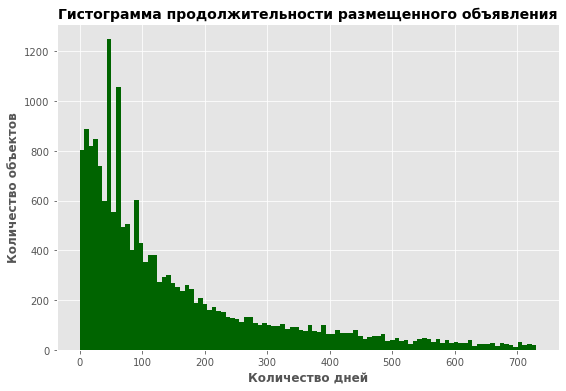

Среднее время продажи квартиры (дней): 180
Медианное время продажи квартиры (дней): 95


In [ ]:
plt.style.use('ggplot')

plt.figure(figsize=(9, 6))
plt.hist(df['days_exposition'].where(lambda x: x > 0).dropna(), bins=100, range=(0, 730), color='DarkGreen')
plt.title('Гистограмма продолжительности размещенного объявления', fontsize=14, fontweight="bold")
plt.xlabel('Количество дней', fontweight="bold")
plt.ylabel('Количество объектов', fontweight="bold")
plt.show()

print(f'Среднее время продажи квартиры (дней):',int(df['days_exposition'].mean()))
print(f'Медианное время продажи квартиры (дней):',int(df['days_exposition'].median()))



***Вывод:*** Из визуализации данных можно наблюдать распределение величин скошенное вправо (right skewed distribution). Среднее и медиана отличаются почти в 2 раза. Это как раз обусловлено типом распределения, где присутствует длинный "хвост" из величин, то есть квартиры которые продавались дольше обычного. Также можем наблюдать несколько пиков на гистограмме, которые визуализируют выбросы в данных. Выбросы могут быть связаны, например, с платными объявлениями у которых истек срок публикации, или результат работы ситемы удаления неактивных объявлений.
Исходя из анализа, быстрой продажей можно назвать срок в 45 дней и меньше(25 процентиль). Долгой продажей - 230 дней и дольше (75 процентиль). 

### Оценка факторов которые больше всего влияют на общую (полную) стоимость объекта.

#### Для получения датасета со значениями без выбросов, сделаем срез из нашей обработанной таблицы `df`. Это позволит нам получить более точную картину в нашем анализе:

In [ ]:
cols = ['last_price', 'total_area', 'kitchen_area', 'living_area', 'days_exposition', 'ceiling_height', 'rooms'] # one or more

Q1 = df[cols].quantile(0.10)
Q3 = df[cols].quantile(0.85)
IQR = Q3 - Q1

good_df = df[~((df[cols] < (Q1 - 1.5 * IQR)) | (df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]    

# Изучаем, есть ли выбивающиеся значения
good_df.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_m2,month,year,km_to_citycenters,floor_cat_n
count,20317.00,20317.00,20317.00,20317.00,20317.00,20317.00,20317.00,20317.00,20317.00,20317.00,...,16260.00,6835.00,16260.00,7818.00,17800.00,20317.00,20317.00,20317.00,20317.00,20317.00
mean,9.91,5415972.71,31.70,1.98,2.67,11.28,31.70,6.15,31.70,0.62,...,0.56,494.48,0.71,531.19,157.05,181981.22,6.41,2017.41,11.89,1.64
std,5.62,2783958.45,14.20,0.93,0.14,6.64,14.20,4.99,14.20,0.98,...,0.76,339.38,0.90,276.03,172.16,73825.04,3.49,0.99,9.57,0.68
min,0.00,2000000.00,10.00,0.00,2.25,1.00,10.00,1.00,10.00,0.00,...,0.00,1.00,0.00,13.00,1.00,24255.80,1.00,2014.00,0.00,0.00
25%,6.00,3550000.00,18.80,1.00,2.60,5.00,18.80,3.00,18.80,0.00,...,0.00,292.00,0.00,315.00,43.00,132768.40,3.00,2017.00,5.00,2.00
50%,10.00,4600000.00,30.00,2.00,2.65,9.00,30.00,5.00,30.00,0.00,...,0.00,458.00,0.00,519.50,90.00,169968.10,6.00,2017.00,12.00,2.00
75%,14.00,6400000.00,40.60,3.00,2.70,16.00,40.60,8.00,40.60,1.00,...,1.00,616.50,1.00,741.00,210.00,217647.10,10.00,2018.00,16.00,2.00
max,50.00,18120000.00,98.00,6.00,3.24,60.00,98.00,33.00,98.00,5.00,...,3.00,3190.00,3.00,1344.00,881.00,1066000.00,12.00,2019.00,66.00,2.00


In [ ]:
good_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20317 entries, 0 to 22089
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          20317 non-null  int64         
 1   last_price            20317 non-null  int64         
 2   total_area            20317 non-null  float64       
 3   first_day_exposition  20317 non-null  datetime64[ns]
 4   rooms                 20317 non-null  int8          
 5   ceiling_height        20317 non-null  float64       
 6   floors_total          20317 non-null  int8          
 7   living_area           20317 non-null  float64       
 8   floor                 20317 non-null  int8          
 9   is_apartment          20317 non-null  bool          
 10  studio                20317 non-null  bool          
 11  open_plan             20317 non-null  bool          
 12  kitchen_area          20317 non-null  float64       
 13  balcony         

In [ ]:
print('Выборка для анализа составляет: {:.2%}'.format(len(good_df)/len(df)))

Выборка для анализа составляет: 91.97%


#### Попробуем определить наличие линейной связи между величинами с помощью корреляции и последующей визуализации.

In [ ]:
# для вычислений корреляции переведем тип этажа в численные переменные

def floor_status(row):
    if row['floor_cat'] == 'первый':
        return 0
    elif row['floor_cat'] == 'последний':
        return 1
    else:
        return 2
    
good_df['floor_cat_n'] = df.apply(floor_status, 1)
df['floor_cat_n'] = df.apply(floor_status, 1)

In [ ]:
good_df_corr = good_df[['total_area', 'living_area',
                        'kitchen_area', 'rooms',
                        'day', 'month',
                        'year', 'last_price', 'floor_cat_n']]
good_df_corr.corr()

,total_area,living_area,kitchen_area,rooms,month,year,last_price,floor_cat_n
total_area,1.00,1.00,1.00,0.89,0.00,-0.04,0.61,-0.06
living_area,1.00,1.00,1.00,0.89,0.00,-0.04,0.61,-0.06
kitchen_area,1.00,1.00,1.00,0.89,0.00,-0.04,0.61,-0.06
rooms,0.89,0.89,0.89,1.00,-0.00,-0.03,0.47,-0.09
month,0.00,0.00,0.00,-0.00,1.00,-0.29,-0.00,0.02
year,-0.04,-0.04,-0.04,-0.03,-0.29,1.00,0.03,0.03
last_price,0.61,0.61,0.61,0.47,-0.00,0.03,1.00,0.11
floor_cat_n,-0.06,-0.06,-0.06,-0.09,0.02,0.03,0.11,1.00


In [ ]:
df_corr = df[['total_area', 'living_area',
                        'kitchen_area', 'rooms',
                        'day', 'month',
                        'year', 'last_price', 'floor_cat_n']]
df_corr.corr()

,total_area,living_area,kitchen_area,rooms,month,year,last_price,floor_cat_n
total_area,1.00,1.00,1.00,0.83,0.00,-0.07,0.68,-0.03
living_area,1.00,1.00,1.00,0.83,0.00,-0.07,0.68,-0.03
kitchen_area,1.00,1.00,1.00,0.83,0.00,-0.07,0.68,-0.03
rooms,0.83,0.83,0.83,1.00,-0.00,-0.05,0.46,-0.07
month,0.00,0.00,0.00,-0.00,1.00,-0.27,0.01,0.01
year,-0.07,-0.07,-0.07,-0.05,-0.27,1.00,-0.05,0.02
last_price,0.68,0.68,0.68,0.46,0.01,-0.05,1.00,0.06
floor_cat_n,-0.03,-0.03,-0.03,-0.07,0.01,0.02,0.06,1.00


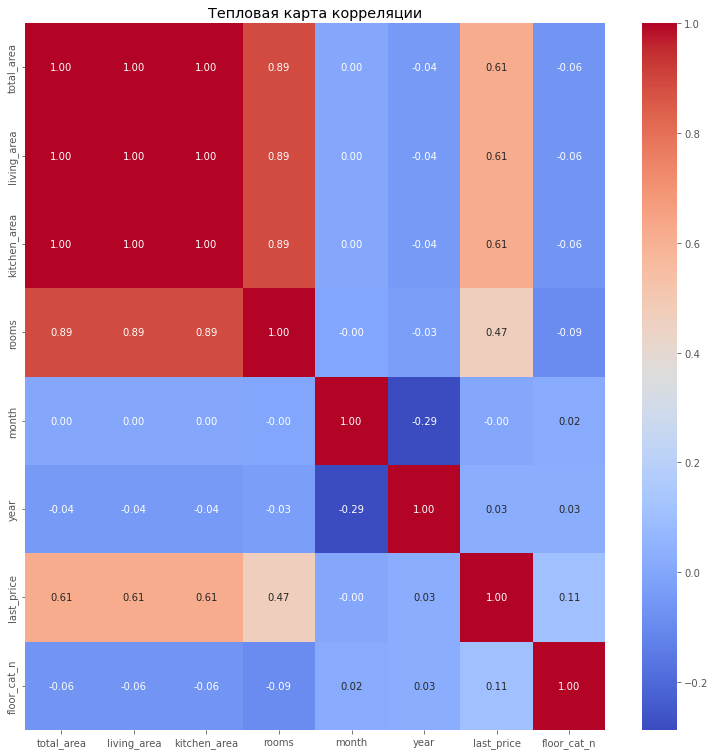

In [ ]:
# построим тепловую карту, коэффициенты корреляции окгруглим до 2 знаков
plt.figure(figsize=(13,13))
sns.heatmap(good_df_corr.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Тепловая карта корреляции')
plt.show()

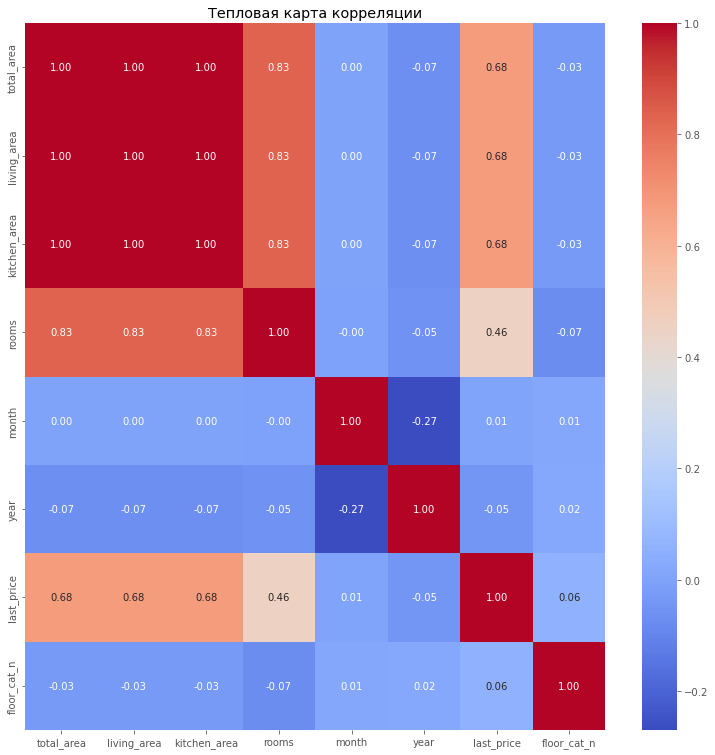

In [ ]:
# построим тепловую карту, коэффициенты корреляции окгруглим до 2 знаков
plt.figure(figsize=(13,13))
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Тепловая карта корреляции')
plt.show()

**Вывод:** Изучив взаимосвязь нескольких величин с помощью хитмэпа, видим что положительный коэффициент корреляции Пирсона указывает на сильное влияние общей площади объекта к цене объекта. Далее следует зависимость цены объекта к жилой площади и площади кухни. Получается, чем больше площадь объекта недвижимости, тем больше цена объекта. Более низкий коэффициент Пирсона наблюдается у параметров: количество комнат и категория этажей. Соответственно зависимость цены объекта от этих параметров более слабая. У остальных параметров коэффициэнт корреляции почти нулевой. Можно утверждать, что линейная связь слабая либо отсутствует вовсе. Бывает, что коэффициент нулевой не потому, что связи между значениями нет, а из-за того, что у неё более сложный, не линейный характер. Потому-то коэффициент корреляции такую связь не берёт.

#### Изучим поведение цен объектов используя наш срез `good_df`. Построим графики, которые покажут зависимость цены от выбранных нами параметров. Для подготовки данных перед визуализацией будем использовать сводные таблицы.

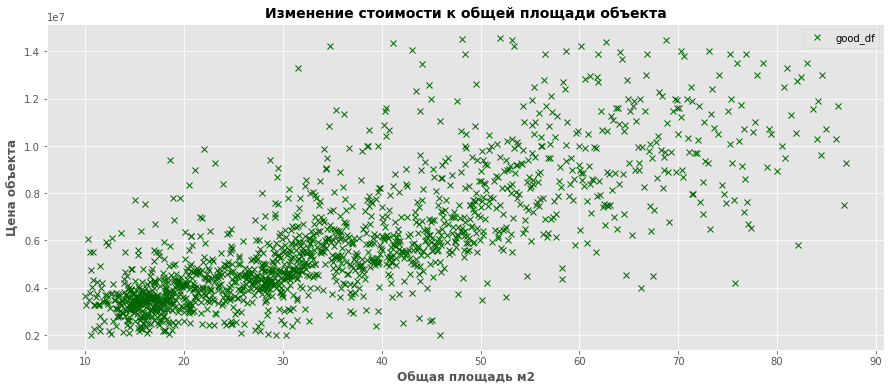

In [ ]:
# сгрупируем данные по столбцу цены на момент снятия с публикации и выполним построение графика 
# с использованием нужных параметров
good_df.groupby('total_area')['last_price'].agg('median').plot(
    x='total_area', style='x', figsize=(15, 6), legend = True, color='DarkGreen')

plt.legend(['good_df'])
plt.title('Изменение стоимости к общей площади объекта', fontsize=14, fontweight="bold")
plt.xlabel('Общая площадь м2', fontweight="bold")
plt.ylabel('Цена объекта', fontweight="bold")
plt.show()

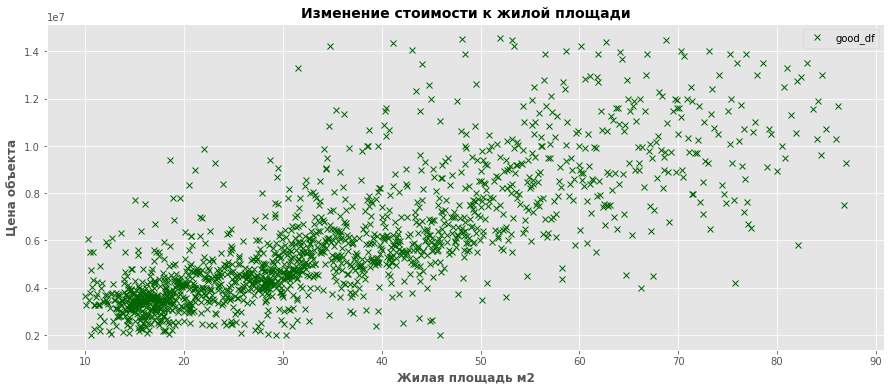

In [ ]:
good_df.groupby('living_area')['last_price'].agg('median').plot(
    x='living_area', style='x', figsize=(15, 6), legend = True, color='DarkGreen')

plt.legend(['good_df'])
plt.title('Изменение стоимости к жилой площади', fontsize=14, fontweight="bold")
plt.xlabel('Жилая площадь м2', fontweight="bold")
plt.ylabel('Цена объекта', fontweight="bold")
plt.show()

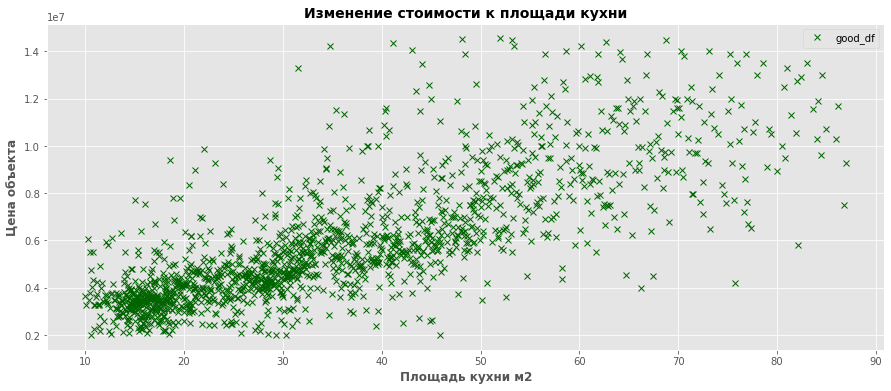

In [ ]:
good_df.groupby('kitchen_area')['last_price'].agg('median').plot(
    x='kitchen_area', style='x', figsize=(15, 6), legend = True, color='DarkGreen')

plt.legend(['good_df'])
plt.title('Изменение стоимости к площади кухни', fontsize=14, fontweight="bold")
plt.xlabel('Площадь кухни м2', fontweight="bold")
plt.ylabel('Цена объекта', fontweight="bold")
plt.show()

**Вывод:** Как и было зачемено выше в пункте 5.2 при помощи корреляции, построенные нами графики также подтверждают зависимость цены от указанных в них параметров. Так, первый график указывает на сильную зависимость общей площади объекта к цене, в соответствии с областью более высокой плотности точек, которая возрастает линейно. Далее, следует график зависимости цены объекта к жилой площади, отображая более слабую зависимость и более низкую плотность величин. И замыкает наш анализ график зависимости цены объекта от площади кухни, указывая на наиболее слабую зависимость из трёх.  
Можно сделать утверждение, что чем больше общая площадь объекта недвижимости, тем больше цена объекта.

#### Построение графиков по датам размещения публикации (день недели, месяц, год).

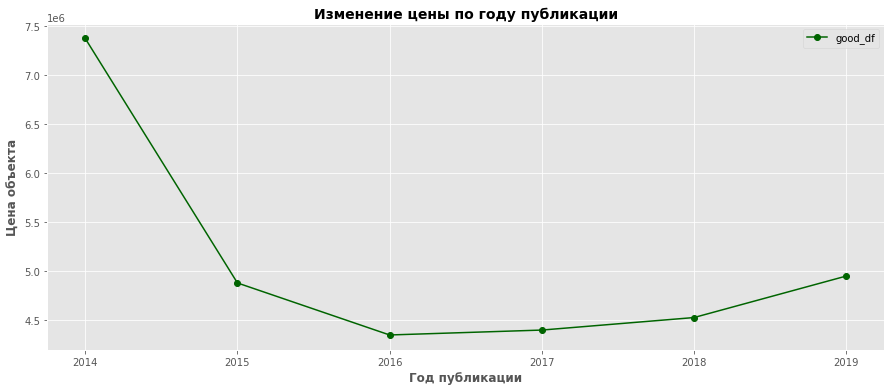

In [ ]:
good_df.groupby('year')['last_price'].agg('median').plot(
    x='year', style='o-', figsize=(15, 6), legend = True, color='DarkGreen')

plt.legend(['good_df'])
plt.title('Изменение цены по году публикации', fontsize=14, fontweight="bold")
plt.xlabel('Год публикации', fontweight="bold")
plt.ylabel('Цена объекта', fontweight="bold")
plt.show()

**Вывод:** Исходя из графика пик стоимости приходится на 2014 год. Можно предложить, что это связано с повышенным интересом инвестировать денежные средства в покупку недвижимости, что вызвало рост цены на рынке. После достаточно сильного спада к 2015 году наблюдаем гомогенность цены за 2016-2017 года. Следующая тенденция роста начала проявляться начиная с 2017 года и заканчивая 2019 годом.

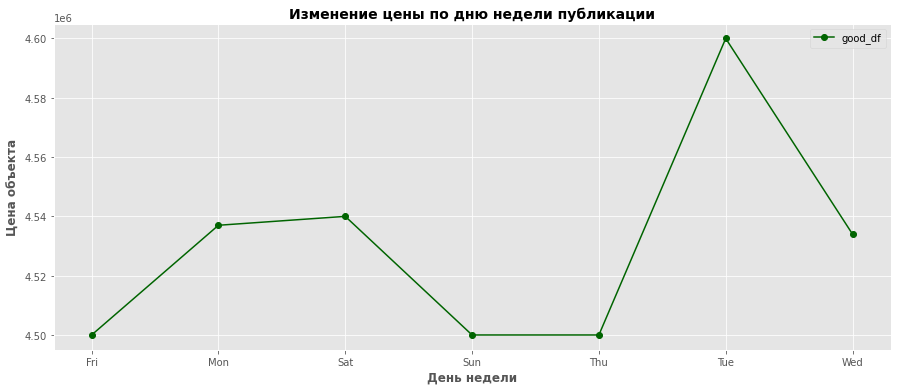

In [ ]:
good_df.groupby('day')['last_price'].agg('median').plot(
    x='day', style='o-', figsize=(15, 6), legend = True, color='DarkGreen')

plt.legend(['good_df'])
plt.title('Изменение цены по дню недели публикации', fontsize=14, fontweight="bold")
plt.xlabel('День недели', fontweight="bold")
plt.ylabel('Цена объекта', fontweight="bold")
plt.show()

Конкретной зависимости цены объекта от дня публикации не выявлено. Можно отметить, что цены публикаций в начале недели немного выше чем в выходные дни.

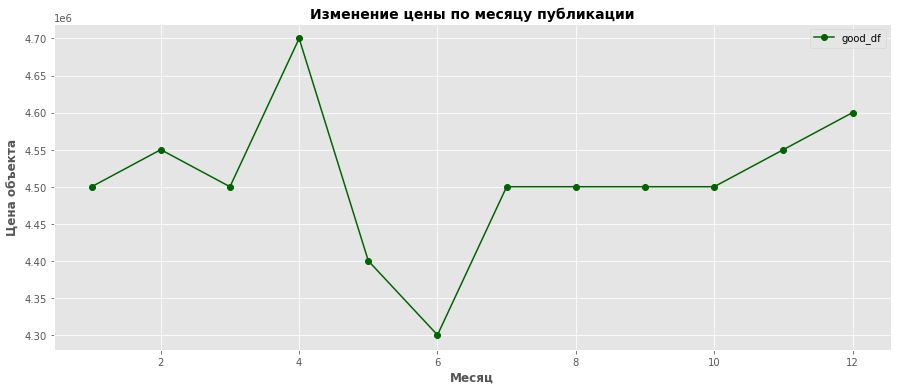

In [ ]:
good_df.groupby('month')['last_price'].agg('median').plot(
    x='month', style='o-', figsize=(15, 6), legend = True, color='DarkGreen')

plt.legend(['good_df'])
plt.title('Изменение цены по месяцу публикации', fontsize=14, fontweight="bold")
plt.xlabel('Месяц', fontweight="bold")
plt.ylabel('Цена объекта', fontweight="bold")
plt.show()

Графическая визуализация зависимости цены публикаций по месяцам, также не показывает сильной зависимости. Можно наблюдать незначительную тенденцию увеличения цен публикаций в летний период времени, с мая по сентябрь.

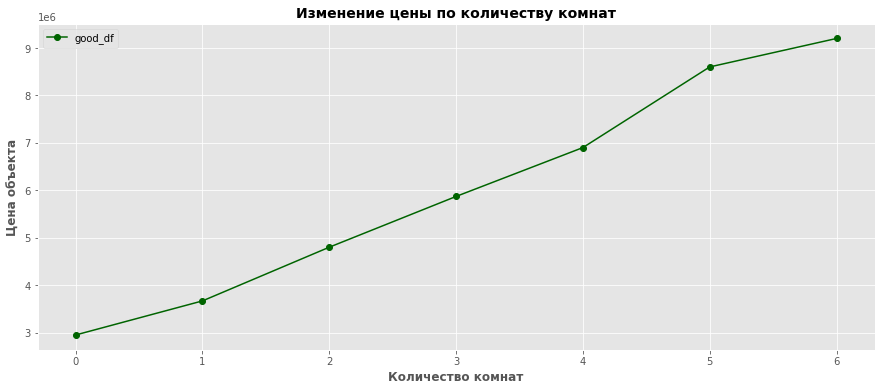

In [ ]:
good_df.groupby('rooms')['last_price'].agg('median').plot(
    x='rooms', style='o-', figsize=(15, 6), legend = True, color='DarkGreen')

plt.legend(['good_df'])
plt.title('Изменение цены по количеству комнат', fontsize=14, fontweight="bold")
plt.xlabel('Количество комнат', fontweight="bold")
plt.ylabel('Цена объекта', fontweight="bold")
plt.show()

Из данного графика можно наблюдать как с ростом числа комнат растет и цена публикаций. Так как с увеличение количества жилых комнат увеличивается и площадь объекта, то соответственно это вызывает рост стоимости объекта и мы можем наблюдать эту зависимость.

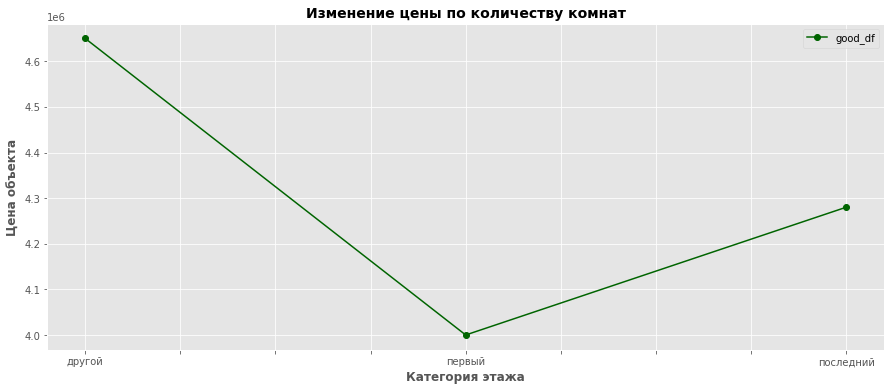

In [ ]:
good_df.groupby('floor_cat')['last_price'].agg('median').plot(
    x='floor_cat', style='o-', figsize=(15, 6), legend = True, color='DarkGreen')

plt.legend(['good_df'])
plt.title('Изменение цены по количеству комнат', fontsize=14, fontweight="bold")
plt.xlabel('Категория этажа', fontweight="bold")
plt.ylabel('Цена объекта', fontweight="bold")
plt.show()

Нельзя увидеть четкую зависимость категории этажа на цену объекта недвижимости. В то же время из графика видно что объекты недвижимости находящиеся на первом этаже уступают в цене другим объектам. Объекты расположенные на последнем этаже имеют чуть большую стоимость чем те, что находятся на первом. Квартиры расположенные между первым и последним этажами имеют более высокую цену в нашей выборке. 

<div class="alert alert-success">
<h2> Комментарий ревьюера v2 <a class="tocSkip"> </h2>

<b>Все супер!👍:</b> Ага, отлично)

#### Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделим населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные найдем по имени в столбце `locality_name`.

In [ ]:
# построим сводную таблицу по значениям из оригинального датасета df
top_10 = df.pivot_table(index='locality_name', 
                                     values='price_per_m2', 
                                     aggfunc=['count', 'mean']
                                    )
# определим колонки с числом объявлений и средней ценой за кв.м. по каждому населенному пункту
# отсортируем результаты по убыванию и выведем первые 10 значений на экран
top_10.columns = ['ads_count', 'mean_price_per_m2']
top = top_10.sort_values(by='ads_count', ascending=False).head(10)

top

,ads_count,mean_price_per_m2
locality_name,,
Санкт-Петербург,15496,210450.93
Мурино,570,173722.35
Кудрово,468,192644.12
Шушары,435,153828.28
Всеволожск,376,134106.03
Пушкин,367,190969.01
Колпино,337,131868.68
Парголово,324,197676.14
Гатчина,287,124436.97


**Вывод:** Из представленных городов, по количеству публикаций объектов недвижимости лидирует город Санкт-Петербург с ценой за кв.м. около 110,000 руб. Замыкает наш Топ-10 рейтинг Петергоф, при этом и цена за кв. м. недвижимости ниже и составляет 83,000 руб.

<div class="alert alert-success">
<h2> Комментарий ревьюера v2 <a class="tocSkip"> </h2>

<b>Все супер!👍:</b> Верно!

#### Выделим квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислим среднюю цену каждого километра. Опишем, как стоимость объектов зависит от расстояния до центра города.

In [ ]:
# создадим условие по выделению всех объектов недвижимоски Санкт-Петербурга с удаленностью 1 км и более от центра
# построим сводную таблицу по средней цене 
spb_center = df.query('km_to_citycenters > 0').pivot_table(index='km_to_citycenters', 
                                             values=['last_price'], 
                                             aggfunc='mean'
                                            ).reset_index()
spb_center.head(12)

,km_to_citycenters,last_price
0,1,16191956.75
1,2,14815946.40
2,3,10919820.79
3,4,11393034.34
4,5,12583258.96
5,6,13221832.14
6,7,13747253.83
7,8,9106251.54
8,9,6959274.53
9,10,6416296.12


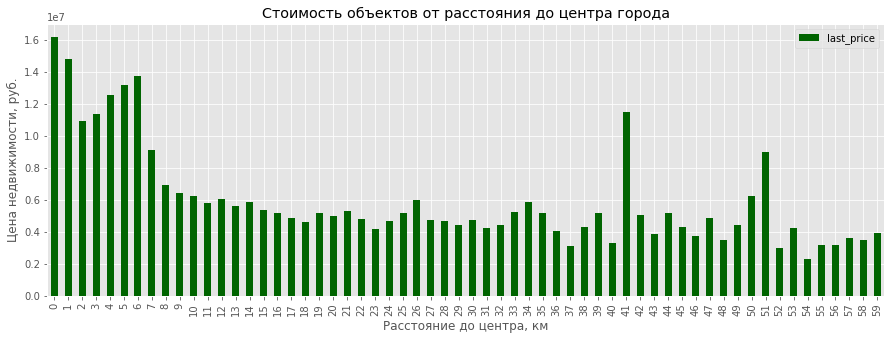

In [ ]:
# представим графически распределения зависимости цены объекта от расстояния до центра Санкт-Петербурга
spb_center.plot(y='last_price', kind='bar', figsize=(15,5),
                                             sharex=True, color='DarkGreen'
                                                  )
plt.ylabel('Цена недвижимости, руб.')
plt.xlabel('Расстояние до центра, км')
plt.title('Cтоимость объектов от расстояния до центра города')
plt.show()

In [ ]:
# посмотрим коэффициент корреляции

print('Корреляция цены и удалённости от центра:','\n')
print(spb_center.corr(),'\n')

Корреляция цены и удалённости от центра: 

                   km_to_citycenters  last_price
km_to_citycenters               1.00       -0.63
last_price                     -0.63        1.00 



**Вывод:** На расстоянии 1-2 км от центра Санкт-Петербурга наблюдается самая высокая цена на недвижимость. С 7-8 км начинается спад и наблюдается некоторое постоянство. Мы можем наблюдать рост цен на 43 км и 55 км. Это может определяться либо большим размером жилой площади (загородные таунхаусы), либо категорией элитной недвижимости. При просмотре корреляции наблюдаем отрицательный коэффициент корреляции Пирсона, так как уменьшение одной величины связано с увеличением другой. То есть с ростом расстояния до центра Санкт-Петербурга цена обьекта недвижимости уменьшается. Что также является подтверждением нашей зависимости.

### Общий вывод

Выполнив полную предобработку данных и изучив их, мы нашли интересные особенности и зависимости, которые существуют на рынке недвижимости. Мы подтвердили зависимости на графиках с помощью корреляции и коэффициента Пирсона. После проведенного нами анализа можем сделать следующие итоговые выводы:

- Наиболее сильное влияние на цену оказывает общая площадь объекта недвижимости и максимальная близость к центру города (на примере Санкт-Петербурга). Чем ближе к центру тем выше цена объектв. Количество комнат также влияет на цену объекта недвижимости, что логично связывать с общей площадью квартиры. Пик цен на объекты пришелся на 2014 год. Можно предложить, что это было связано с повышенным интересом инвестировать денежные средства в покупку недвижимости, что вызвало рост цен на рынке. 

- Исходя из сроков продаже объектов, чаще всего квартиру продавали за 95 дней. Мы пришли к выводу если публикация была в листинге меньше 45 дней, то это считается быстрой продажей, а если дольше 230 дней - это долгая продажа. Присутствовало большое число квартир, проданных всего за несколько дней после публикации.

- Первый этаж оказался значительно дешевле остальных категорий этажности. Также стоимость квартиры на последнем этаже ниже, чем на остальных, кроме первого.

- Выяснили стоимость квадратного метра в топ-10 населённых пунктов по количеству объявлений. Лидер - город Санкт-Петербург с ценой 114,848 руб за кв.м.